<a href="https://colab.research.google.com/github/IrinaOltean14/Research/blob/main/FeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import time
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms

In [3]:
images_folder_path = '/content/drive/MyDrive/SemArt/Images'
train_csv_path = '/content/drive/MyDrive/SemArt/semart_train.csv'
val_csv_path = '/content/drive/MyDrive/SemArt/semart_val.csv'
test_csv_path = '/content/drive/MyDrive/SemArt/semart_test.csv'

In [4]:
def load_csv(csv_path, images_folder_path):
    df = pd.read_csv(csv_path, sep='\t', encoding='ISO-8859-1')
    # Create the full image path
    df['image_path'] = df['IMAGE_FILE'].apply(lambda x: os.path.join(images_folder_path, x))
    return df[['image_path', 'SCHOOL', 'TYPE']]

train_df = load_csv(train_csv_path, images_folder_path)
val_df = load_csv(val_csv_path, images_folder_path)
test_df = load_csv(test_csv_path, images_folder_path)

In [33]:
school_encoder = LabelEncoder()
type_encoder = LabelEncoder()

train_df['SCHOOL'] = school_encoder.fit_transform(train_df['SCHOOL'])
train_df['TYPE'] = type_encoder.fit_transform(train_df['TYPE'])
val_df['SCHOOL'] = school_encoder.fit_transform(val_df['SCHOOL'])
val_df['TYPE'] = type_encoder.fit_transform(val_df['TYPE'])
test_df['SCHOOL'] = school_encoder.fit_transform(test_df['SCHOOL'])
test_df['TYPE'] = type_encoder.fit_transform(test_df['TYPE'])

In [6]:
num_classes_school = len(school_encoder.classes_)
num_classes_type = len(type_encoder.classes_)

print(f"Number of classes for SCHOOL: {num_classes_school}")
print(f"Number of classes for TYPE: {num_classes_type}")
print(train_df.head())

Number of classes for SCHOOL: 26
Number of classes for TYPE: 10
                                          image_path  SCHOOL  TYPE
0  /content/drive/MyDrive/SemArt/Images/19873-1da...      11     7
1  /content/drive/MyDrive/SemArt/Images/18759-gua...      15     3
2  /content/drive/MyDrive/SemArt/Images/04589-tem...      15     7
3  /content/drive/MyDrive/SemArt/Images/15104-mag...      16     7
4  /content/drive/MyDrive/SemArt/Images/36582-pao...       6     5


In [7]:
IMG_SIZE = (224, 224)

train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [8]:
class SEMARTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        school_label = self.dataframe.iloc[idx]['SCHOOL']
        type_label = self.dataframe.iloc[idx]['TYPE']

        return image, torch.tensor(school_label, dtype=torch.long), torch.tensor(type_label, dtype=torch.long)

In [21]:
# Create dataset instances
train_dataset = SEMARTDataset(train_df, transform=train_transforms)
val_dataset = SEMARTDataset(val_df, transform=val_test_transforms)
test_dataset = SEMARTDataset(test_df, transform=val_test_transforms)

# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [10]:
print(train_dataset)

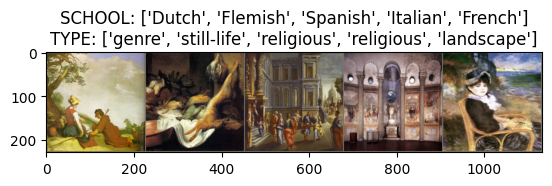

In [11]:
def imshow(inp, school_labels=None, type_labels=None):
    """Display images in a grid with school and type labels."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert tensor to HWC for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Reverse normalization
    inp = np.clip(inp, 0, 1)  # Clip values to be between 0 and 1
    plt.imshow(inp)

    # Display labels if provided
    if school_labels and type_labels:
        plt.title(f"SCHOOL: {school_labels}\nTYPE: {type_labels}")

    plt.pause(0.001)  # Pause to update plot
    plt.show()


# Get a batch of training data
images, school_labels, type_labels = next(iter(train_loader))

# Select the first 5 images and their labels
images = images[:5]
school_labels = school_labels[:5]
type_labels = type_labels[:5]

# Make a grid from the 5 selected images
out = torchvision.utils.make_grid(images, nrow=5)

# Decode school and type labels for the first 5 images
school_labels_text = [school_encoder.classes_[label] for label in school_labels]
type_labels_text = [type_encoder.classes_[label] for label in type_labels]

# Display the grid of 5 images with the decoded labels
imshow(out, school_labels=school_labels_text, type_labels=type_labels_text)

In [12]:
!pip install wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.5/317.5 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


In [13]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [15]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm

# Set the device to TPU
device = xm.xla_device()

print(f"Using device: {device}")

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


Using device: xla:0


In [37]:
from tqdm import tqdm

def train_model_multi_task(model, criterion_task1, criterion_task2, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25, checkpoint_path="drive/MyDrive/model_checkpointsFe", alpha=0.5, beta=0.5, patience=5):
    wandb.init(project="SemArt_TransferLearning_fe")
    since = time.time()

    os.makedirs(checkpoint_path, exist_ok=True)

    best_acc = 0.0
    start_epoch = 0

    checkpoint_file = os.path.join(checkpoint_path, 'checkpoint.pth')
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    epochs_no_improve = 0


    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('-' * 10)

        wandb.log({"epoch": epoch})

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss_task1 = 0.0
            running_loss_task2 = 0.0
            running_corrects_task1 = 0
            running_corrects_task2 = 0

            for inputs, labels_task1, labels_task2 in tqdm(dataloaders[phase], desc=f"{phase} Phase"):
                inputs = inputs.to(device)
                labels_task1 = labels_task1.to(device)
                labels_task2 = labels_task2.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    task1_output, task2_output = model(inputs)
                    # task1_output = torch.argmax(task1_preds, dim=1)
                    # task2_output = torch.argmax(task2_preds, dim=1)
                    # print(task1_output)
                    # print(task2_output)

                    # Compute losses for both tasks
                    loss_task1 = criterion_task1(task1_output, labels_task1)
                    loss_task2 = criterion_task2(task2_output, labels_task2)

                    # Combine the losses (weighted sum)
                    total_loss = alpha * loss_task1 + beta * loss_task2

                    # Backward pass and optimization only in the training phase
                    if phase == 'train':
                        total_loss.backward()
                        optimizer.step()
                        xm.mark_step()  # Ensures TPU steps forward after the batch

                # Update running loss and correct predictions
                running_loss_task1 += loss_task1.item() * inputs.size(0)
                running_loss_task2 += loss_task2.item() * inputs.size(0)
                running_corrects_task1 += torch.sum(torch.argmax(task1_output, dim=1) == labels_task1)
                running_corrects_task2 += torch.sum(torch.argmax(task2_output, dim=1) == labels_task2)


            if phase == 'train':
                scheduler.step()

            # Calculate loss and accuracy for each task
            epoch_loss_task1 = running_loss_task1 / dataset_sizes[phase]
            epoch_loss_task2 = running_loss_task2 / dataset_sizes[phase]
            epoch_acc_task1 = running_corrects_task1.double() / dataset_sizes[phase]
            epoch_acc_task2 = running_corrects_task2.double() / dataset_sizes[phase]

            # Combine the accuracy and loss metrics
            combined_loss = alpha * epoch_loss_task1 + beta * epoch_loss_task2
            combined_acc = alpha * epoch_acc_task1 + beta * epoch_acc_task2

            print(f'{phase} Loss (Task1): {epoch_loss_task1:.4f} Acc (Task1): {epoch_acc_task1:.4f} Loss (Task2): {epoch_loss_task2:.4f} Acc (Task2): {epoch_acc_task2:.4f}')
            print(f'Combined Loss: {combined_loss:.4f} Combined Accuracy: {combined_acc:.4f}')

            wandb.log({
                f"{phase} loss (Task1)": epoch_loss_task1,
                f"{phase} accuracy (Task1)": epoch_acc_task1,
                f"{phase} loss (Task2)": epoch_loss_task2,
                f"{phase} accuracy (Task2)": epoch_acc_task2,
                f"{phase} combined loss": combined_loss,
                f"{phase} combined accuracy": combined_acc
            })

            if phase == 'val':
                if combined_loss < best_loss:
                    best_loss = combined_loss
                    best_model_wts = model.state_dict()
                    epochs_no_improve = 0  # Reset counter when improvement is found
                    if best_acc < combined_acc:
                        best_acc = combined_acc

                    # Save best model checkpoint
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_acc': best_acc,
                        'best_loss': best_loss,
                    }, checkpoint_file)
                else:
                    epochs_no_improve += 1

        print()
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation loss for {patience} epochs.")
            break

    # Load best model weights and end WandB run
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best combined Acc: {best_acc:4f}')
    wandb.finish()

    return model

In [24]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [39]:
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, num_classes_type, num_classes_school):
        super(ResNet18FeatureExtractor, self).__init__()

        # Load pre-trained ResNet18 model
        model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

        # Freeze all layers except the final fully connected layers
        for param in model.parameters():
            param.requires_grad = False

        self.features = nn.Sequential(*list(model.children())[:-1])  # Remove the final fully connected layer

        # Add new fully connected layers for multi-task output
        self.type_fc = nn.Linear(model.fc.in_features, num_classes_type)  # Output for Task 1 (type)
        self.school_fc = nn.Linear(model.fc.in_features, num_classes_school)  # Output for Task 2 (school)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)

        type_output = self.type_fc(x)

        school_output = self.school_fc(x)

        # # Apply softmax (if classification task)
        # school_output = F.softmax(school_output, dim=1)
        # type_output = F.softmax(type_output, dim=1)

        # print("Schhol output:", school_output)
        # print("Type output:",type_output)

        return school_output, type_output

model_ft = ResNet18FeatureExtractor(num_classes_type, num_classes_school)

model_ft = model_ft.to(device)

criterion_type = nn.CrossEntropyLoss()
criterion_school = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(list(model_ft.type_fc.parameters()) + list(model_ft.school_fc.parameters()), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

model_ft = train_model_multi_task(
    model=model_ft,
    criterion_task1=criterion_school,
    criterion_task2=criterion_type,
    optimizer=optimizer_ft,
    scheduler=exp_lr_scheduler,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    num_epochs=10,
    checkpoint_path="drive/MyDrive/model_checkpointsFe",
    alpha=0.5,
    beta=0.5
)

epoch,▁
epoch,0


Epoch 0/9
----------


train Phase: 100%|██████████| 602/602 [02:18<00:00,  4.36it/s]


train Loss (Task1): 1.7946 Acc (Task1): 0.4447 Loss (Task2): 1.2459 Acc (Task2): 0.6071
Combined Loss: 1.5203 Combined Accuracy: 0.5259


val Phase: 100%|██████████| 34/34 [00:07<00:00,  4.32it/s]


val Loss (Task1): 4.7170 Acc (Task1): 0.0309 Loss (Task2): 1.0851 Acc (Task2): 0.6473
Combined Loss: 2.9010 Combined Accuracy: 0.3391

Epoch 1/9
----------


train Phase: 100%|██████████| 602/602 [02:18<00:00,  4.36it/s]


train Loss (Task1): 1.6539 Acc (Task1): 0.4847 Loss (Task2): 1.0261 Acc (Task2): 0.6682
Combined Loss: 1.3400 Combined Accuracy: 0.5765


val Phase: 100%|██████████| 34/34 [00:08<00:00,  4.05it/s]


val Loss (Task1): 4.5430 Acc (Task1): 0.0505 Loss (Task2): 1.0017 Acc (Task2): 0.6726
Combined Loss: 2.7723 Combined Accuracy: 0.3616

Epoch 2/9
----------


train Phase: 100%|██████████| 602/602 [02:17<00:00,  4.39it/s]


train Loss (Task1): 1.6090 Acc (Task1): 0.4930 Loss (Task2): 0.9836 Acc (Task2): 0.6782
Combined Loss: 1.2963 Combined Accuracy: 0.5856


val Phase: 100%|██████████| 34/34 [00:08<00:00,  4.17it/s]


val Loss (Task1): 4.6119 Acc (Task1): 0.0702 Loss (Task2): 0.9871 Acc (Task2): 0.6782
Combined Loss: 2.7995 Combined Accuracy: 0.3742

Epoch 3/9
----------


train Phase: 100%|██████████| 602/602 [02:17<00:00,  4.37it/s]


train Loss (Task1): 1.5844 Acc (Task1): 0.5030 Loss (Task2): 0.9564 Acc (Task2): 0.6877
Combined Loss: 1.2704 Combined Accuracy: 0.5953


val Phase: 100%|██████████| 34/34 [00:07<00:00,  4.34it/s]


val Loss (Task1): 4.6647 Acc (Task1): 0.0767 Loss (Task2): 0.9746 Acc (Task2): 0.6838
Combined Loss: 2.8197 Combined Accuracy: 0.3803

Epoch 4/9
----------


train Phase: 100%|██████████| 602/602 [02:18<00:00,  4.35it/s]


train Loss (Task1): 1.5579 Acc (Task1): 0.5109 Loss (Task2): 0.9399 Acc (Task2): 0.6925
Combined Loss: 1.2489 Combined Accuracy: 0.6017


val Phase: 100%|██████████| 34/34 [00:08<00:00,  4.13it/s]


val Loss (Task1): 4.8889 Acc (Task1): 0.0580 Loss (Task2): 0.9496 Acc (Task2): 0.6969
Combined Loss: 2.9192 Combined Accuracy: 0.3775

Epoch 5/9
----------


train Phase: 100%|██████████| 602/602 [02:18<00:00,  4.35it/s]


train Loss (Task1): 1.5462 Acc (Task1): 0.5142 Loss (Task2): 0.9310 Acc (Task2): 0.6919
Combined Loss: 1.2386 Combined Accuracy: 0.6030


val Phase: 100%|██████████| 34/34 [00:08<00:00,  4.06it/s]


val Loss (Task1): 4.9240 Acc (Task1): 0.0571 Loss (Task2): 0.9560 Acc (Task2): 0.6950
Combined Loss: 2.9400 Combined Accuracy: 0.3761

Epoch 6/9
----------


train Phase: 100%|██████████| 602/602 [02:21<00:00,  4.25it/s]


train Loss (Task1): 1.5341 Acc (Task1): 0.5154 Loss (Task2): 0.9210 Acc (Task2): 0.6960
Combined Loss: 1.2276 Combined Accuracy: 0.6057


val Phase: 100%|██████████| 34/34 [00:08<00:00,  4.07it/s]


val Loss (Task1): 4.8030 Acc (Task1): 0.0720 Loss (Task2): 0.9599 Acc (Task2): 0.6819
Combined Loss: 2.8815 Combined Accuracy: 0.3770

Early stopping at epoch 6 due to no improvement in validation loss for 5 epochs.
Training complete in 17m 7s
Best combined Acc: 0.361553


epoch,▁▂▃▅▆▇█
train accuracy (Task1),▁▅▆▇███
train accuracy (Task2),▁▆▇▇███
train combined accuracy,▁▅▆▇███
train combined loss,█▄▃▂▂▁▁
train loss (Task1),█▄▃▂▂▁▁
train loss (Task2),█▃▂▂▁▁▁
val accuracy (Task1),▁▄▇█▅▅▇
val accuracy (Task2),▁▅▅▆██▆
val combined accuracy,▁▅▇██▇▇
val combined loss,▆▁▂▃▇█▆
